# **Scalable Variational Quantum Algorithm utilizing QFT for Poisson Equation**

In [1]:
import random
import numpy as np
import matplotlib as mpl
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, transpile, ClassicalRegister
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler, SamplerOptions
from qiskit_ionq import IonQProvider

from qiskit.circuit import ParameterVector
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import Isometry


from functions import *
from Laplacian1D import *
from derivatives import *
from numerator import *

### **Initialize Simulator and Hardware Backend**

In [ ]:
import os

# IonQ Simulator
os.environ['IONQ_API_KEY'] = 'BU5YwsZpbahvhbxSOEc9qMCvyCqhmxq8'
my_api_key = os.getenv("IONQ_API_KEY")
provider = IonQProvider(my_api_key)
simulator_backend = provider.get_backend("ionq_simulator", gateset = 'native')
simulator_backend.set_options(noise_model="ideal")

hardware_backend = QiskitRuntimeService().backend('ibm_yonsei')

### **Set Parameters & Source Function**

In [3]:
grid_num = 256
one_dim_grid_num = int(np.sqrt(grid_num))
num_shots = 2**19

### **Initialize Sampler**

In [ ]:
options_sampler = SamplerOptions()
options_sampler.default_shots = num_shots
sampler = Sampler(mode = hardware_backend, options = options_sampler)

### **Create Ansatz**

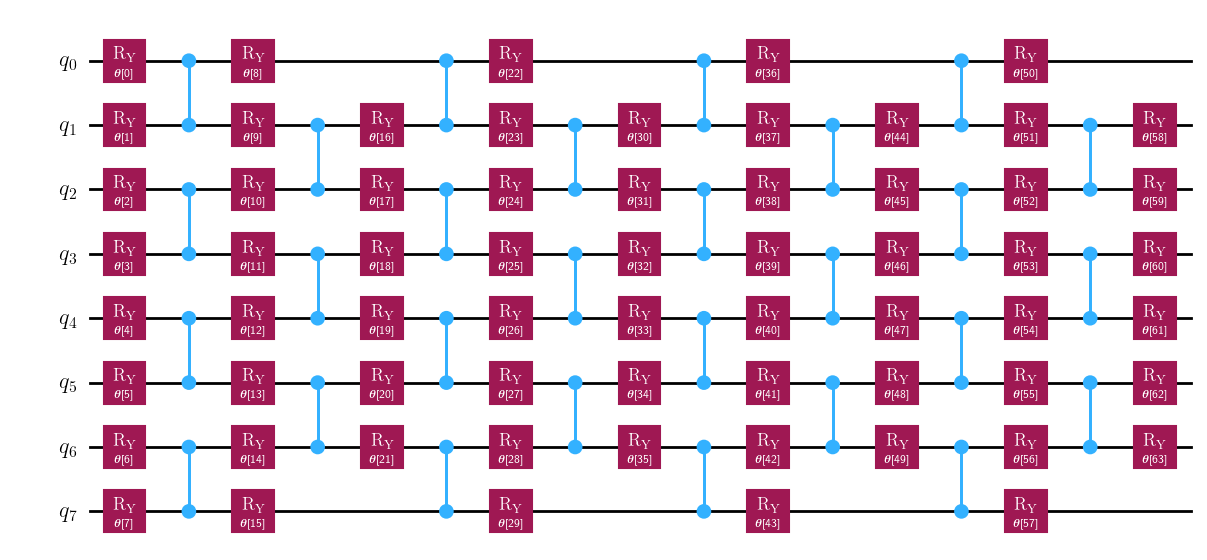

In [34]:
num_qubits = int(np.log2(grid_num))
num_qubits1D = int(num_qubits / 2)
ansatz_depth = 4
param_num = num_qubits + ansatz_depth * (2 * num_qubits - 2)

parameters = ParameterVector(r'$\boldsymbol{\theta}$', length=param_num)

psi_param_circuit = create_parameterized_ansatz(num_qubits, ansatz_depth, parameters)
psi_param_gate = psi_param_circuit.to_gate(label = r'$\left|\psi(\boldsymbol{\theta})\right\rangle$')
psi_param_circuit.draw('mpl', fold = -1)

### **Set Source Function**

In [25]:
alpha_0 = 0.5
alpha_1 = 1.81 * 10**(-5)
eta = np.arctan(np.sqrt(2)**(num_qubits1D + 2) * alpha_1 / alpha_0)

b_0 = np.sqrt(2) * np.array([0,0,0,1,1,0,0,0])
b_0 = np.kron(b_0, np.sqrt(0.5) * np.array([1,1]))
b_0 = np.kron(b_0, np.array([1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]))
b_1 = np.ones(grid_num)
b = alpha_0 * b_0 + alpha_1 * b_1

beta_0 = alpha_0 * np.linalg.norm(b_0) / np.linalg.norm(b)
beta_1 = alpha_1 * np.linalg.norm(b_1) / np.linalg.norm(b)

### **Design Cost Function (Simulator)**

In [13]:
import numerator
import Laplacian2D.Laplacian2D_simulator
import Laplacian2D.Laplacian2D_hardware

def cost_function_simulator(params):
    
    num = numerator.fpsi_Choi_simulator(params, parameters, psi_param_gate, eta, num_qubits, simulator_backend, num_shots)
    num *= 2 * (beta_0 ** 2 + beta_1 ** 2)
    
    denom_y = Laplacian2D.Laplacian2D_simulator.laplacian_evs_2D_simulator_neumann(params, parameters, psi_param_gate, num_qubits, simulator_backend, num_shots, 'y')
    denom_x = Laplacian2D.Laplacian2D_simulator.laplacian_evs_2D_simulator_periodic(params, parameters, psi_param_gate, num_qubits, simulator_backend, num_shots, 'x')
    denom = (denom_x + denom_y) * grid_num * grid_num
    
    cost_function = 0.5 * num / denom
    
    return cost_function

trace_distances = []
def callback_fn(params):
    classical_psi = make_classical_psi(num_qubits, ansatz_depth, params, reverse=True)
    trace_distance = 1 - np.inner(classical_psi, analytic_psi)**2
    trace_distance = np.sqrt(trace_distance)
    trace_distances.append(trace_distance)
    print(f"[Callback] Trace Distance: {trace_distance}")

### **Conduct Optimization (Gradient-Free)**

In [ ]:
from scipy.optimize import minimize
from scipy.optimize import Bounds

initial_params = np.random.rand(param_num) * np.pi
bounds = Bounds([0]*param_num, [np.pi]*param_num)

result = minimize(
    cost_function_simulator,
    initial_params,
    method='Powell',
    bounds=bounds,
    callback=callback_fn,
    options={
        'disp': True,
        'maxiter': 1000000,
        'maxfev': 10000000
    }
)


c:\Users\MPMC\anaconda3\envs\cwq\Lib\site-packages\matplotlib\cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\MPMC\anaconda3\envs\cwq\Lib\site-packages\matplotlib\cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


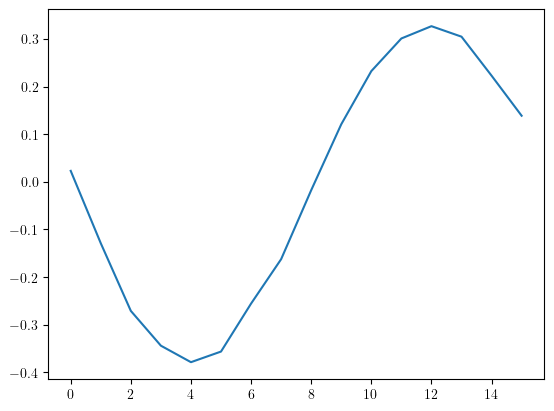

In [ ]:
optimal_params_simulator = np.array(result.x)
classical_psi = make_classical_psi(num_qubits, ansatz_depth, optimal_params_simulator, reverse = True)

plt.figure(figsize = (7,7))
plt.plot(classical_psi)
plt.show()